In [1]:
def set_size(width=371.30264, fraction=1.4, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [2]:
width = 371.30264  # Minimum Thesis
width = 307.28987  # Presentation

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})
plt.rcParams.update({"axes.grid" : True})
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [4]:
import numpy as np
import control
import scipy.signal as sig
import matplotlib.pyplot as plt

F1 = 0.8
F2 = 0.1
k11 = 1
k22 = 1.3

q0s = 0.2

Q0s = np.arange(0.1,10,0.1)
XData = []
YData = []

h2s = (q0s/k22)**2
h1s = (q0s/k11)**2 + h2s

K1 = k11*(1/(2*np.sqrt(h1s)))
K2 = k22*(1/(2*np.sqrt(h2s)))

A = np.array([[-K1/F1, 0], [K1/F2, -K2/F2]])
B = np.array([[1/F1], [1/F2]])
C = np.array([[1, 0], [0, 1]])
D = np.array([[0], [0]])

Ts = 0.5
A_d, B_d, C_d, D_d, _ = sig.cont2discrete((A,B,C,D), Ts)
Q = np.array([[1,0],[0,1]])
R = np.array([[0.001]])

K, S, E = control.dlqr(A_d,B_d,Q,R)

In [5]:
def simulate(system, sim_time=300, faults=False):
    t_out = []
    y_ref = []
    y_out = []
    u_out = []
    labels = []

    q0_max = 10
    q0_min = 0
    lin_degradation = np.linspace(0, -10, sim_time)

    q0s = 5
    h2s = (q0s/k22)**2
    h1s = (q0s/k11)**2 + h2s
    h_ref = [h1s, h2s]
    h_ode = h_ref
    state = 0
    fault_sensor = 0
    fault_actuator = 0
    for t in range(sim_time):
      tspan = [t, t+Ts]
      if t == 50:
        q0s = 4
        h2s = (q0s/k22)**2
        h1s = (q0s/k11)**2 + h2s
        h_ref = [h1s, h2s]
        state = 1
      elif t == 100:
        q0s = 0.5
        h2s = (q0s/k22)**2
        h1s = (q0s/k11)**2 + h2s
        h_ref = [h1s, h2s]
        state = 2
      elif t == 200:
        q0s = 2.5
        h2s = (q0s/k22)**2
        h1s = (q0s/k11)**2 + h2s
        h_ref = [h1s, h2s]
        state = 3
      labels.append(state)
      
      if t > 2:
        if labels[-2] == -1 and labels[-2] != -1:  
          labels[-1] = -1
        if labels[-2] == -1 and labels[-2] != -1:  
          labels[-1] = -1
        
      K = np.array([0.5, 0.1])
      if faults:
        fault_sensor = random.randint(1, 50)
      else:
        fault_sensor = 0
      u = -K @ (np.array(h_ode if fault_sensor != 1 else h_ode*0) - np.array(h_ref))
      q0 = u + q0s
      q0 = max(min(q0, q0_max), q0_min)
      if faults:
        fault_actuator = random.randint(1, 50)
      else:
        fault_actuator = 0
      if fault_actuator == 1:
        q0 = q0*0.5
      x_ode = solve_ivp(system, tspan, h_ode, args=(q0,), method="RK45")
      h_ode = x_ode.y[:,-1]
      
      if fault_sensor == 1:  
        labels[-1] = -1
      if fault_actuator == 1:  
        labels[-1] = -1
      y_out.append(h_ode if fault_sensor != 1 else h_ode*0)
      y_ref.append(h_ref)
      t_out.append(t)
      u_out.append(q0)
    y_ref = np.array(y_ref)
    y_out = np.array(y_out)
    t_out = np.array(t_out)
    u_out = np.array(u_out)

    return t_out, y_ref, y_out, u_out, labels
    

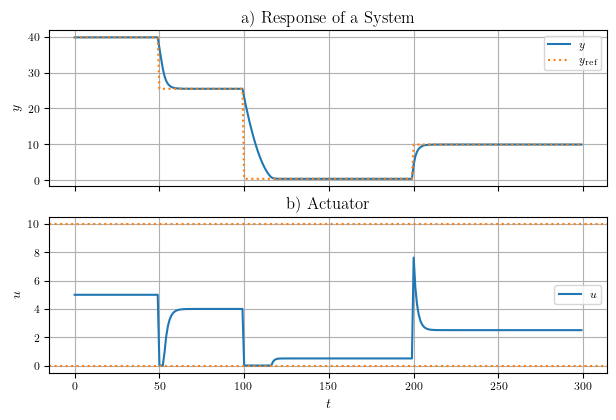

In [22]:
from scipy.integrate import solve_ivp
import random
random.seed(40)
def system(t, x, u):
  h1, h2 = x
  q0 = u

  dh1_dt = q0/F1 - k11/F1 * np.sqrt(h1-h2)
  dh2_dt = k11/F2 * np.sqrt(h1-h2) - k22/F2 * np.sqrt(h2)

  return [dh1_dt, dh2_dt]

q0_max = 10
q0_min = 0
t_out, y_ref, y_out_s, u_out_s, labels = simulate(system, sim_time=300, faults=False)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=set_size(subplots=(1,1)), sharex=True)
axs[0].plot(t_out, y_out_s[:,0], label='$y$')
axs[0].plot(t_out, y_ref[:,0], label=r'$y_{\mathrm{ref}}$', linestyle=":")
axs[0].set_ylabel('$y$')
axs[0].set_title('a) Response of a System')
axs[0].legend()

axs[1].plot(t_out, u_out_s, label='$u$')
color = next(axs[1]._get_lines.prop_cycler)
axs[1].axhline(q0_max, **color, linestyle=":")
axs[1].axhline(q0_min, **color, linestyle=":")
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$u$')
axs[1].set_title('b) Actuator')
axs[1].legend()

plt.savefig("simulation.pdf")
plt.show()

/tmp/ipykernel_128/3161464010.py:8: RuntimeWarning: invalid value encountered in sqrt
  dh1_dt = q0/F1 - k11/F1 * np.sqrt(h1-h2) + random.normalvariate(0,5)*1+h1/50
/tmp/ipykernel_128/3161464010.py:9: RuntimeWarning: invalid value encountered in sqrt
  dh2_dt = k11/F2 * np.sqrt(h1-h2) - k22/F2 * np.sqrt(h2) + random.normalvariate(0,5)*1+h1/50


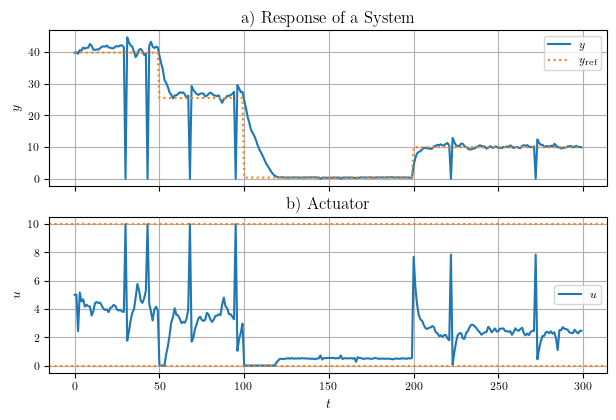

In [171]:
from scipy.integrate import solve_ivp
import random
random.seed(40)
def system_perturbed(t, x, u):
  h1, h2 = x
  q0 = u

  dh1_dt = q0/F1 - k11/F1 * np.sqrt(h1-h2) + random.normalvariate(0,5)*1+h1/50
  dh2_dt = k11/F2 * np.sqrt(h1-h2) - k22/F2 * np.sqrt(h2) + random.normalvariate(0,5)*1+h1/50

  return [dh1_dt, dh2_dt]

q0_max = 10
q0_min = 0
t_out, y_ref, y_out_r, u_out_r, labels = simulate(system_perturbed, sim_time=300, faults=True)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=set_size(subplots=(1,1)), sharex=True)
axs[0].plot(t_out, y_out_r[:,0], label='$y$')
axs[0].plot(t_out, y_ref[:,0], label=r'$y_{\mathrm{ref}}$', linestyle=":")
axs[0].set_ylabel('$y$')
axs[0].set_title('a) Response of a System')
axs[0].legend()

axs[1].plot(t_out, u_out_r, label='$u$')
color = next(axs[1]._get_lines.prop_cycler)
axs[1].axhline(q0_max, **color, linestyle=":")
axs[1].axhline(q0_min, **color, linestyle=":")
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$u$')
axs[1].set_title('b) Actuator')
axs[1].legend()

plt.savefig("real.pdf")
plt.show()

/tmp/ipykernel_128/2517276468.py:8: RuntimeWarning: invalid value encountered in sqrt
  dh1_dt = q0/F1 - k11/F1 * np.sqrt(h1-h2) + random.normalvariate(0,5)*1+h1/50
/tmp/ipykernel_128/2517276468.py:9: RuntimeWarning: invalid value encountered in sqrt
  dh2_dt = k11/F2 * np.sqrt(h1-h2) - k22/F2 * np.sqrt(h2) + random.normalvariate(0,5)*1+h1/50


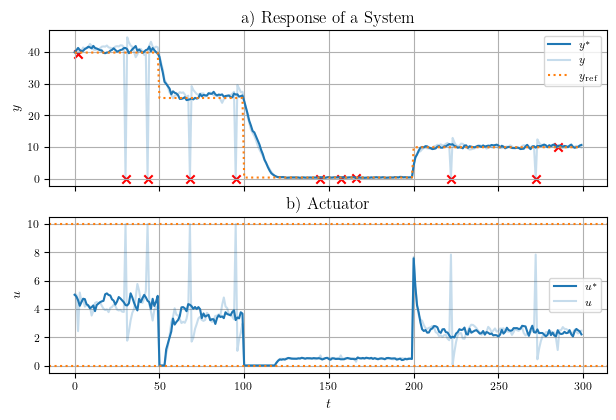

In [24]:
from scipy.integrate import solve_ivp
import random
random.seed(40)
def system_perturbed(t, x, u):
  h1, h2 = x
  q0 = u

  dh1_dt = q0/F1 - k11/F1 * np.sqrt(h1-h2) + random.normalvariate(0,5)*1+h1/50
  dh2_dt = k11/F2 * np.sqrt(h1-h2) - k22/F2 * np.sqrt(h2) + random.normalvariate(0,5)*1+h1/50

  return [dh1_dt, dh2_dt]
q0_max = 10
q0_min = 0
t_out, y_ref, y_out, u_out, _ = simulate(system_perturbed, sim_time=300, faults=False)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=set_size(subplots=(1,1)), sharex=True)
color = next(axs[0]._get_lines.prop_cycler)
axs[0].plot(t_out, y_out[:,0], **color, label='$y^*$')
axs[0].plot(t_out, y_out_r[:,0], label='$y$', **color, alpha=0.25)
axs[0].plot(t_out, y_ref[:,0], label=r'$y_{\mathrm{ref}}$', linestyle=":")
axs[0].scatter(t_out[np.array(labels) == -1], 
               y_out_r[:, 0][np.array(labels) == -1], 
               marker='x', color='red')
axs[0].set_ylabel('$y$')
axs[0].set_title('a) Response of a System')
axs[0].legend()

color = next(axs[1]._get_lines.prop_cycler)
axs[1].plot(t_out, u_out, **color, label='$u^*$')
axs[1].plot(t_out, u_out_r, label='$u$', **color, alpha=0.25)
color = next(axs[1]._get_lines.prop_cycler)
axs[1].axhline(q0_max, **color, linestyle=":")
axs[1].axhline(q0_min, **color, linestyle=":")
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$u$')
axs[1].set_title('b) Actuator')
axs[1].legend()

plt.savefig("imagined.pdf")
plt.show()

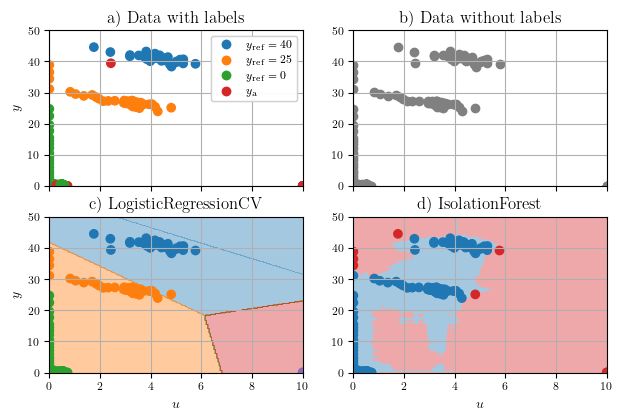

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import ListedColormap
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


def get_cmap(Z):
    return ListedColormap(colors[0:len(np.unique(Z))])


X = np.array([u_out_r, y_out_r[:, 0]]).T
y = labels
X_train = X[0:200, :]
X_test = X[201::, :]
y_train = y[0:200]
y_train = np.where(np.array(y_train) == -1, 4, y_train)
y_test = y[201::]
# Initialize KMeans with 3 clusters and fit the data
unsupervised = IsolationForest(contamination=0.05)  # nu=outliers_fraction)
unsupervised.fit(X_train)

# Initialize DecisionTreeClassifier and fit the data
supervised = DecisionTreeClassifier(random_state=10, max_depth=4)
supervised = LogisticRegressionCV(max_iter=1000,
                                  class_weight={4: 3})
supervised.fit(StandardScaler().fit_transform(X_train), y_train)
y_pred = supervised.predict(StandardScaler().fit_transform(X_train))

# Set up the figure with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=set_size(subplots=(2, 2)),
                        sharex=True)

# Plot the data with labels
s = axs[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(colors[0:4]))
axs[0, 0].set_ylabel('$y$')
axs[0, 0].set_title('a) Data with labels')
legend1 = axs[0, 0].legend(
    s.legend_elements()[0],
    [r"$y_{\mathrm{ref}} = 40$",
     r"$y_{\mathrm{ref}} = 25$",
     r"$y_{\mathrm{ref}} = 0$",
     r"$y_{\mathrm{a}}$"])
axs[0, 0].add_artist(legend1)

# Plot the data without labels
axs[0, 1].scatter(X_train[:, 0], X_train[:, 1], c='grey')
axs[0, 1].set_title('b) Data without labels')

xx, yy = np.meshgrid(np.linspace(0, 10, 200), np.linspace(0, 50, 200))
Z = supervised.predict(StandardScaler().fit_transform(
    np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
# Plot the decision lines of the Decision Tree Classifier
axs[1, 0].contourf(xx, yy, Z, alpha=0.4, cmap=get_cmap(Z))
axs[1, 0].scatter(X_train[:, 0], X_train[:, 1], c=np.choose(y_pred, colors))
axs[1, 0].set_title(f'c) {supervised.__class__.__name__}')
axs[1, 0].set_xlabel('$u$')
axs[1, 0].set_ylabel('$y$')

Z = unsupervised.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot the data with cluster assignments
axs[1, 1].scatter(X_train[:, 0], X_train[:, 1], c=np.choose(np.where(
    unsupervised.predict(X_train) == -1, 0, unsupervised.predict(X_train)), ['#d62728', '#1f77b4']))
axs[1, 1].imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=ListedColormap(['#d62728', '#1f77b4']),
    alpha=0.4,
    aspect="auto",
    origin="lower",
)
axs[1, 1].set_title(f'd) {unsupervised.__class__.__name__}')
axs[1, 1].set_xlabel('$u$')

xlim = (0, 10)
ylim = (0, 50)
for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# Show the plot
plt.savefig("un_supervised.pdf")
plt.show()

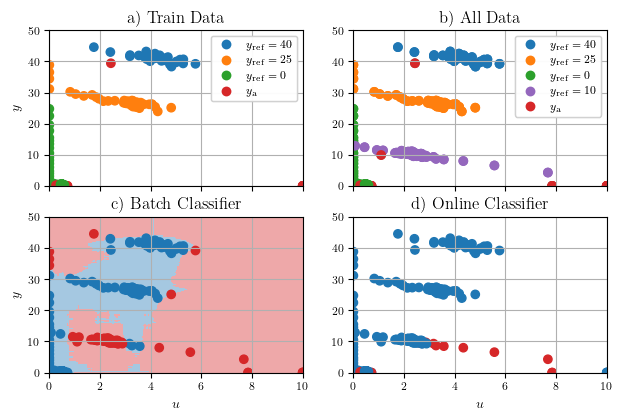

In [283]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
import random
random.seed(40)
from matplotlib.colors import ListedColormap
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def get_cmap(Z):
  return ListedColormap(colors[0:len(np.unique(Z))])


# Add one sample from missing class to the test set
y = np.where(np.array(y) == -1, 5, y)
X_test = X
y_test = X

# Initialize DecisionTreeClassifier and fit the data
supervised = make_pipeline(
  StandardScaler(), 
  LogisticRegressionCV(max_iter=1000,
                       class_weight={4: 3}))
supervised.fit(X_train, y_train)

from river import tree
from river import linear_model
from river import preprocessing
from river import optim
from river import anomaly

class QuantileFilter(anomaly.QuantileFilter):
  def __init__(self, anomaly_detector, q: float, protect_anomaly_detector=True):
        super().__init__(
            anomaly_detector=anomaly_detector,
            protect_anomaly_detector=protect_anomaly_detector,
            q=q
        )
  def predict_one(self, *args):
    score = self.score_one(*args)
    return score >= (self.quantile.get() or np.inf)
online = (
    preprocessing.MinMaxScaler() |
    QuantileFilter(
        anomaly.HalfSpaceTrees(
            window_size=150,
            n_trees=30,
            height=10,
            seed=40),
        q=0.98
    )
)

# Visualize data
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=set_size(subplots=(2,2)),
                        sharex=True)

# Subplot 1: train data
s = axs[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(colors[0:4]))
axs[0, 0].set_title("a) Train Data")
axs[0, 0].set_ylabel('$y$')
legend1 = axs[0, 0].legend(
    s.legend_elements()[0],
    [r"$y_{\mathrm{ref}} = 40$",
     r"$y_{\mathrm{ref}} = 25$",
     r"$y_{\mathrm{ref}} = 0$",
     r"$y_{\mathrm{a}}$"])
axs[0, 0].add_artist(legend1)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

xx, yy = np.meshgrid(np.linspace(0, 10, 200), np.linspace(0, 50, 200))
Z = unsupervised.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot the data with cluster assignments
axs[1, 0].scatter(X[:, 0], X[:, 1], c=np.choose(np.where(
    unsupervised.predict(X) == -1, 0, unsupervised.predict(X)), ['#d62728', '#1f77b4']))
axs[1, 0].imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=ListedColormap(['#d62728', '#1f77b4']),
    alpha=0.4,
    aspect="auto",
    origin="lower",
)
axs[1, 0].set_title('c) Batch Classifier')
axs[1, 0].set_xlabel('$u$')
axs[1, 0].set_ylabel('$y$')

# Subplot 2: test data
axs[0, 1].scatter(X[:, 0], X[:, 1], c=np.choose(y, colors))
s3 = axs[0, 1].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors[0:5]))
axs[0, 1].set_title("b) All Data")
legend1 = axs[0, 1].legend(
    s3.legend_elements()[0],
    [r"$y_{\mathrm{ref}} = 40$",
     r"$y_{\mathrm{ref}} = 25$",
     r"$y_{\mathrm{ref}} = 0$",
     r"$y_{\mathrm{ref}} = 10$",
     r"$y_{\mathrm{a}}$"])
axs[0, 1].add_artist(legend1)

# Subplot 4: online model
y_online = []
for x_, y_ in zip(X, y):
  x_ = {i: v for i, v in enumerate(x_)}
  y_pred = online.predict_one(x_)
  y_online.append(y_pred) if y_pred is not None else y_online.append(0)
  online.learn_one(x_, y_)
axs[1, 1].scatter(X[:, 0], X[:, 1], c=np.choose(y_online, ['#1f77b4', '#d62728']))
axs[1, 1].set_title('d) Online Classifier')
axs[1, 1].set_xlabel('$u$')

xlim = (0, 10)
ylim = (0, 50)
for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Show the plot
plt.savefig("online.pdf")
plt.show()

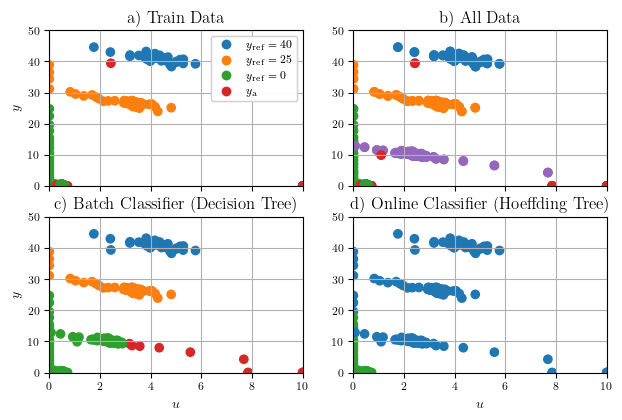

In [256]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
import random
random.seed(40)
from matplotlib.colors import ListedColormap
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def get_cmap(Z):
  return ListedColormap(colors[0:len(np.unique(Z))])


# Add one sample from missing class to the test set
y = np.where(np.array(y) == -1, 5, y)
X_test = X
y_test = X

# Initialize DecisionTreeClassifier and fit the data
supervised = make_pipeline(
  StandardScaler(), 
  LogisticRegressionCV(max_iter=1000,
                       class_weight={4: 3}))
supervised.fit(X_train, y_train)

from river import tree
from river import linear_model
from river import preprocessing
from river import optim
from river import multiclass

online = tree.HoeffdingAdaptiveTreeClassifier(
    grace_period=10,
    delta=1e-4,
    seed=5
)
online = (
    preprocessing.StandardScaler() |
    multiclass.OutputCodeClassifier(linear_model.LogisticRegression(optimizer=optim.SGD(.1), l2=2), code_size=4)
)

# Visualize data
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=set_size(subplots=(2,2)),
                        sharex=True)

# Subplot 1: train data
s = axs[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(colors[0:4]))
axs[0, 0].set_title("a) Train Data")
axs[0, 0].set_ylabel('$y$')
legend1 = axs[0, 0].legend(
    s.legend_elements()[0],
    [r"$y_{\mathrm{ref}} = 40$",
     r"$y_{\mathrm{ref}} = 25$",
     r"$y_{\mathrm{ref}} = 0$",
     r"$y_{\mathrm{a}}$"])
axs[0, 0].add_artist(legend1)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Subplot 3: batch model
y_pred = supervised.predict(X)
axs[1, 0].scatter(X[:, 0], X[:, 1], c=np.choose(y_pred, colors))
axs[1, 0].set_title('c) Batch Classifier (Decision Tree)')
axs[1, 0].set_xlabel('$u$')
axs[1, 0].set_ylabel('$y$')

# Subplot 2: test data
axs[0, 1].scatter(X[:, 0], X[:, 1], c=np.choose(y, colors))
s3 = axs[0, 1].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors[0:5]))
axs[0, 1].set_title("b) All Data")

# Subplot 4: online model
y_online = []
for x_, y_ in zip(X, y):
  x_ = {i: v for i, v in enumerate(x_)}
  y_pred = online.predict_one(x_)
  y_online.append(y_pred) if y_pred is not None else y_online.append(0)
  online.learn_one(x_, y_)
axs[1, 1].scatter(X[:, 0], X[:, 1], c=np.choose(y_online, colors))
axs[1, 1].set_title('d) Online Classifier (Hoeffding Tree)')
axs[1, 1].set_xlabel('$u$')

xlim = (0, 10)
ylim = (0, 50)
for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Show the plot
plt.savefig("online.pdf")
plt.show()

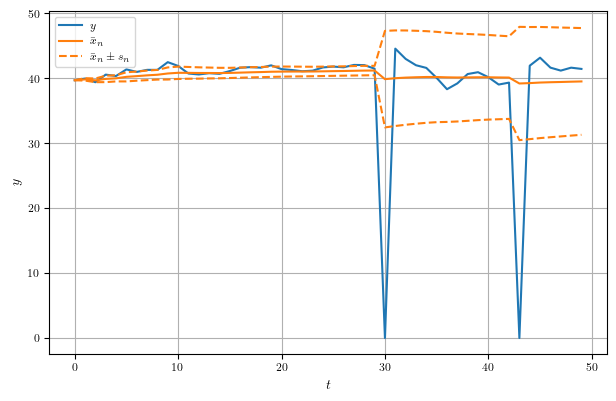

In [284]:
import numpy as np
import matplotlib.pyplot as plt

# generate random data
data = X_train[0:50,1]

# initialize variables for Welford's algorithm
n = 0
mean = 0
M2 = 0

# calculate the mean and standard deviation using Welford's algorithm
means = []
stds = []
for x in data:
    n += 1
    delta = x - mean
    mean += delta / n
    delta2 = x - mean
    M2 += delta * delta2
    if n > 1:
        std = np.sqrt(M2 / (n - 1))
    else:
        std = 0
    means.append(mean)
    stds.append(std)

# plot the data and the running mean and standard deviation
fig, ax = plt.subplots(figsize=set_size())
ax.plot(data, label='$y$')
color = next(ax._get_lines.prop_cycler)
ax.plot(means, label=r'$\bar x_n$', **color)
ax.plot(np.array(means) + np.array(stds), linestyle='--', 
        label=r'$\bar x_n \pm s_n$', **color)
ax.plot(np.array(means) - np.array(stds), linestyle='--', **color)
ax.legend()
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')

# Show the plot
plt.savefig("welford.pdf")
plt.show()


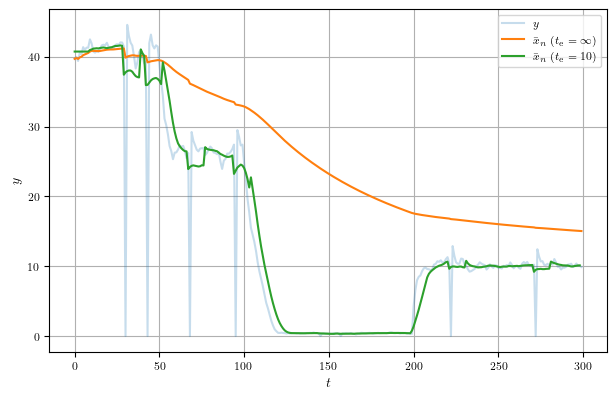

In [288]:
import numpy as np
import matplotlib.pyplot as plt

def welford(data):
    n = 0
    mean = 0
    M2 = 0
    means = []
    stds = []
    for x in data:
        n += 1
        delta = x - mean
        mean += delta/n
        delta2 = x - mean
        M2 += delta * delta2
        var = M2/(n-1) if n > 1 else 0
        std = np.sqrt(var)
        means.append(mean)
        stds.append(std)
    return means, stds

def inverse_welford(data, window_size):
    window = data[:window_size]
    window_mean = np.mean(window)
    window_std = np.std(window)
    means = [window_mean] * (window_size - 1)
    stds = [window_std] * (window_size - 1)
    for i, x in enumerate(data[window_size:], start=window_size):
        prev = data[i - window_size]
        next_ = x
        window_mean = window_mean + (next_ - prev) / window_size
        window_std = np.sqrt(((window_size - 2) * window_std ** 2 + (next_ - prev) ** 2 + (next_ - window_mean) * (prev - window_mean)) / (window_size - 1))
        means.append(window_mean)
        stds.append(window_std)
    return means, stds

# Generate example data
data = X[:,1]
window_size = 10
# Calculate running means using Welford algorithm and inverse Welford algorithm
welford_means, w_std = welford(data)
inverse_welford_means, iw_std = inverse_welford(data, window_size=window_size)

# Plot the data and running means
fig, ax = plt.subplots(figsize=set_size())
ax.plot(data, label='$y$',
        alpha=0.25)
ax.plot(welford_means, label=r'$\bar x_n$ ($t_\mathrm{e} = \infty$)')
ax.plot(inverse_welford_means, 
        label=fr'$\bar x_n$ ($t_\mathrm e = {window_size}$)')
ax.legend()
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')

# ax.set_title('Running Means using Welford Algorithm with and without expiration')
# Show the plot
plt.savefig("welford_compare.pdf")
plt.show()

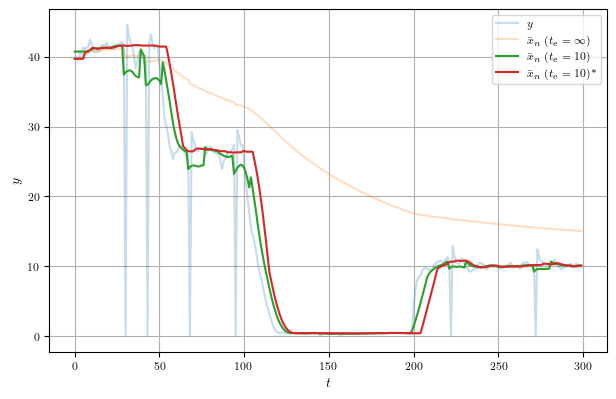

In [289]:
import pandas as pd
inverse_welford_means_prot = pd.read_csv(
    "inv_wel_prot_mean.csv", index_col=0).iloc[:,0].values
# Generate example data
data = X[:,1]
window_size = 10
# Calculate running means using Welford algorithm and inverse Welford algorithm
welford_means, w_std = welford(data)
inverse_welford_means, iw_std = inverse_welford(data, window_size=window_size)

# Plot the data and running means
fig, ax = plt.subplots(figsize=set_size())
ax.plot(data, label='$y$',
        alpha=0.25)
ax.plot(welford_means, label=r'$\bar x_n$ ($t_\mathrm{e} = \infty$)',
        alpha=0.25)
ax.plot(inverse_welford_means, 
        label=fr'$\bar x_n$ ($t_\mathrm e = {window_size}$)')
ax.plot(inverse_welford_means_prot, 
        label=fr'$\bar x_n$ ($t_\mathrm e = {window_size}$)*')
ax.legend()
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')
# ax.set_title('Running Means using Welford Algorithm with and without expiration')
# Show the plot
plt.savefig("welford_compare_prot.pdf")
plt.show()

In [291]:
residuals = data[-len(inverse_welford_means)::] - inverse_welford_means

In [292]:
inverse_welford_stds_prot = pd.read_csv(
    "inv_wel_prot_std.csv", index_col=0).iloc[:,0].values

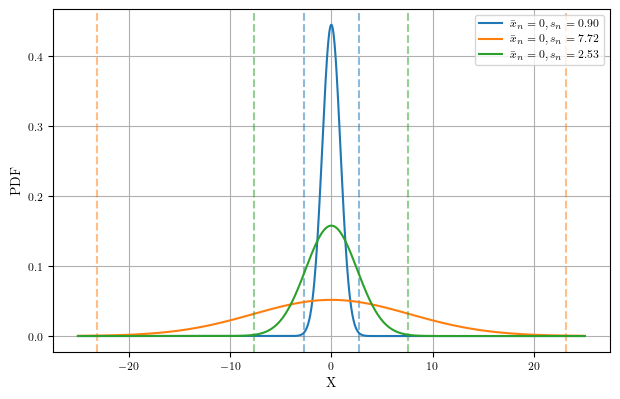

In [296]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
random.seed(40)
# Define the mean and standard deviation lists
mean_list = [0]*3  # Example mean values
std_list = random.sample(list(inverse_welford_stds_prot),3)   # Example standard deviation values
std_list = random.sample(iw_std,4)   # Example standard deviation values

# Generate a range of x-values
x = np.linspace(-25, 25, 1000)

# Create a figure and axes
fig, ax = plt.subplots(figsize=set_size())

# Iterate over mean and std lists
for mean, std in zip(mean_list, std_list):
    # Calculate the PDF values for the current mean and std
    y = norm.pdf(x, mean, std)

    # Plot the PDF curve
    line, = ax.plot(x, y, label=fr"$\bar x_n={mean}, s_n={std:04.2f}$")
    # Get the color of the current plot
    line_color = line.get_color()
    # Calculate 3 sigma bounds
    sigma = 3 * std
    ax.axvline(mean + sigma, linestyle='--', color=line_color, alpha=0.5)
    ax.axvline(mean - sigma, linestyle='--', color=line_color, alpha=0.5)

# Set plot title and labels
ax.set_xlabel("X")
ax.set_ylabel("PDF")

# Add a legend
ax.legend()

# Display the plot
plt.savefig("sigmas.pdf")
plt.show()


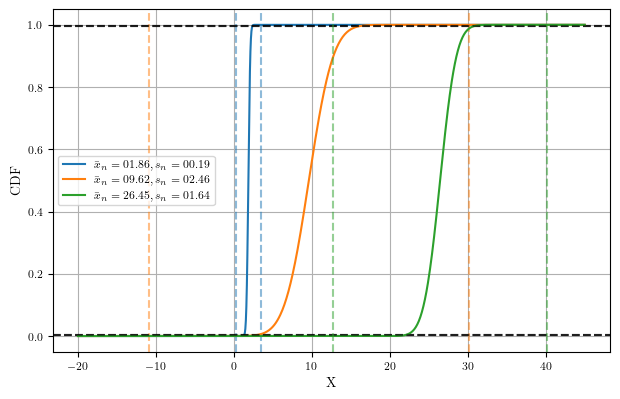

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
random.seed(3)
# Define the mean and standard deviation lists
mean_list = random.sample(inverse_welford_means,3)  # Example mean values
std_list = random.sample(iw_std,3)   # Example standard deviation values

# Generate a range of x-values
x = np.linspace(-20, 45, 1000)

# Create a figure and axes
fig, ax = plt.subplots(figsize=set_size())

# Iterate over mean and std lists
for mean, std in zip(mean_list, std_list):
    # Calculate the PDF values for the current mean and std
    y_pdf = norm.pdf(x, mean, std)
    y_cdf = norm.cdf(x, mean, std)

    # Plot the PDF curve
    line, = ax.plot(x, y_cdf, label=fr"$\bar x_n={mean:05.2f}, s_n={std:05.2f}$")

    # Calculate 3 sigma bounds
    sigma = 3 * std

    # Get the color of the current plot
    line_color = line.get_color()

    # Mark the probabilities with dashed horizontal lines
    ax.axhline(0.9973, linestyle='--', color='k', alpha=0.5)
    ax.axhline(1-0.9973, linestyle='--', color='k', alpha=0.5)
    ax.axvline(norm.ppf(0.9973, mean, sigma), linestyle='--',
               color=line_color, alpha=0.5)
    ax.axvline(norm.ppf(1-0.9973, mean, sigma), linestyle='--',
               color=line_color, alpha=0.5)

# Set plot title and labels
ax.set_xlabel("X")
ax.set_ylabel("CDF")

# Add a legend
ax.legend()

# Display the plot
plt.savefig("cdf_ppf.pdf")
plt.show()

In [ ]:
from scipy.stats import norm
# Generate data for the Gaussian distribution
mu = 0
sigma = 1
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
pdf = norm.pdf(x, mu, sigma)

# Define the sigma levels for the vertical lines
sigma_levels = [-3, -2, -1, 1, 2, 3]

# Define the x-axis tick positions and labels for the sigma regions
xtickvals = [mu + level*sigma for level in sigma_levels]
xticklabels = [f'{level}$\sigma$' for level in sigma_levels]

# Create the plot
fig, ax = plt.subplots(figsize=set_size())

# Add the Gaussian probability density function trace
ax.plot(x, pdf, label='PDF')

# Add the vertical lines for the sigma levels
for i, level in enumerate(sigma_levels):
    color = next(ax._get_lines.prop_cycler) if i == 0 else color
    ax.axvline(x=mu + level*sigma, **color, 
               linestyle='--', label='sigma' if i == 0 else None)
    
# Update the legend
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = [], []
for handle, label in zip(handles, labels):
    if label not in new_labels:
        new_handles.append(handle)
        new_labels.append(label)
ax.legend(new_handles, new_labels)

# Update the axis labels and tick positions
ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.set_xticks(xtickvals)
ax.set_xticklabels(xticklabels)

# Show the plot
plt.savefig("sigmas.pdf", bbox_inches='tight')
plt.show()
